### A Python implementation of burst detection algorithm of action potentials from David's blog

The original post: [link](https://spikesandbursts.wordpress.com/2023/08/24/patch-clamp-data-analysis-in-python-bursts/) 

I modified for my own use.

- 1. bandpass filter
- 2. find peaks
- 3. isi interval & histogram
- 4. detect bursts

Yile Wang


In [10]:
import numpy as np
import pandas as pd
 
import scipy
from scipy import signal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import skew, kurtosis
 
import matplotlib.pyplot as plt
from os.path import join as pjoin

# If you want to display interactive plots using the ipympl backend:
# %matplotlib widget 
# Ipympl creates multiple interactive plots so you need to close them:
# plt.close('all') 

### Load data

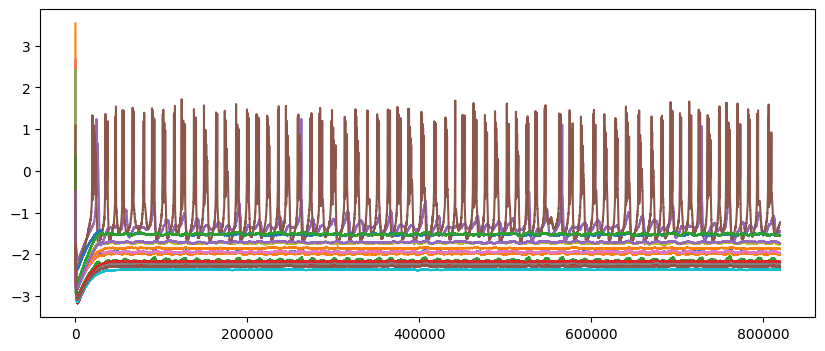

In [11]:
basedir = "/Users/yilewang/Downloads"
only_gc = pjoin(basedir, "local_inhibition_lfp_gc")
# read mega data
mega_data = pd.read_excel('/Users/yilewang/workspaces/data4project/mega_table.xlsx', sheet_name='tvb_parameters')

# Sampling rate
fs = 81920.0
 
node_names = ['aCNG-L', 'aCNG-R','mCNG-L','mCNG-R',
              'pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L',
              'PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMP-R',
              'mTEMp-L','mTEMp-R']

# Quick plot to see the trace/s
gr, ca, gc  = 'AD', '0306A', '0.015'

sample_data = np.load(pjoin(only_gc,gr, f"{ca}_{gc}.npy"))

plt.figure(figsize=(10,4))
for index, i in enumerate(node_names):
    plt.plot(sample_data[:,0,index,0])

pCNG_L = sample_data[:,0,4,0]
pCNG_R = sample_data[:,0,5,0]
# Select the sweep and/or channel
# abf.setSweep(10)  # Sweep
# abf.setSweep(sweepNumber=0, channel=0)  # Sweep and channel

In [12]:

# conduct signal downsample first
def down_sample(data, fs, new_fs):
    new_data = scipy.signal.decimate(data, int(fs/new_fs), axis=0, zero_phase=True)
    return new_data

# generate a sos bandpass filter function
def butter_bandpass(lowcut, highcut, fs, data, order=5):
    nyq = 0.5 * fs # nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    sos = signal.butter(order, [low, high], analog=False, btype="band", output="sos")
    filtered_signal = signal.sosfiltfilt(sos, data)
    return filtered_signal

# pCNG_R = down_sample(pCNG_R, fs, 8192)
#pCNG_R_filtered = butter_bandpass(30, 100, 8192, pCNG_R, order=5)
# filtered_signal = pCNG_R_filtered

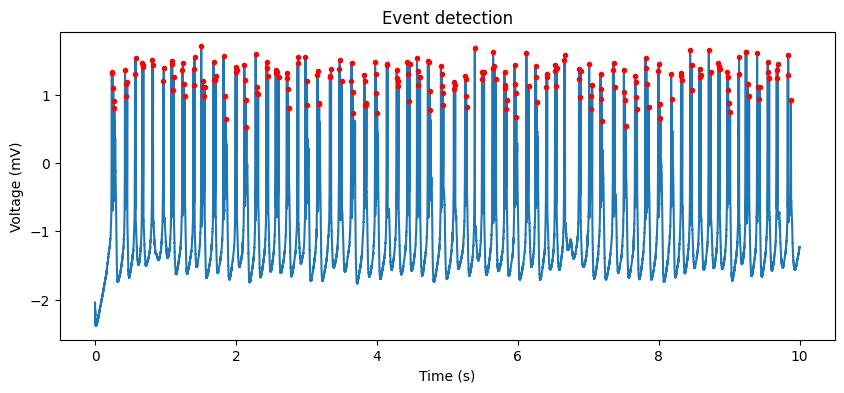

,spike,spike_index,spike_time,inst_freq,isi_s,width,rise_half_ms,decay_half_ms,spike_peak,spike_amplitude
0,1,19571,0.238904,inf,0.000000,2.744174,2.004449,0.739725,1.333392,3.075428
1,2,20250,0.247192,120.648012,0.008289,1.572406,0.995457,0.576949,1.316872,2.001517
2,3,21229,0.259143,83.677222,0.011951,1.969814,1.327480,0.642334,1.095465,1.791824
3,4,21966,0.268140,111.153324,0.008997,2.298234,1.566491,0.731744,0.913886,1.483456
4,5,22532,0.275049,144.734982,0.006909,2.354404,1.583126,0.771277,0.801374,1.223569
...,...,...,...,...,...,...,...,...,...,...
219,220,793146,9.681958,167.525562,0.005969,1.671768,1.097809,0.573960,1.250532,1.877424
220,221,793688,9.688574,151.143911,0.006616,1.901821,1.289707,0.612114,1.449651,2.980661
221,222,805486,9.832593,6.943550,0.144019,1.634167,1.062680,0.571488,1.293897,1.935544
222,223,805995,9.838806,160.943026,0.006213,1.814406,1.214476,0.599930,1.590934,3.149959


In [13]:
# Assign the variables here to simplify the code
time = np.arange(0, len(pCNG_R)) / fs  # Time in seconds
peaks_signal = pCNG_R  # Or signal_filtered
 
# Set parameters for the Find peaks function (set to None if not needed)
thresh_min = -2                     # Min threshold to detect spikes
thresh_prominence = 1              # Min spike amplitude  
thresh_min_width = 0.5 * (fs/1000)  # Min required width in ms
distance_min = 1 * (fs/1000)        # Min horizontal distance between peaks
pretrigger_window = (1.5 * fs)/1000
posttrigger_window = (2 * fs)/1000
 
# Find peaks function
peaks, peaks_dict = find_peaks(peaks_signal, 
           height=thresh_min, 
           threshold=thresh_min,  
           distance=distance_min,  
           prominence=thresh_prominence,  
           width=thresh_min_width, 
           wlen=None,       # Window length to calculate prominence
           rel_height=0.5,  # Relative height at which the peak width is measured
           plateau_size=None)
  
# Create table with results
spikes_table = pd.DataFrame(columns = ['spike', 'spike_index', 'spike_time',
                                       'inst_freq', 'isi_s',
                                       'width', 'rise_half_ms', 'decay_half_ms',
                                       'spike_peak', 'spike_amplitude'])
 
spikes_table.spike = np.arange(1, len(peaks) + 1)
spikes_table.spike_index = peaks
spikes_table.spike_time = peaks / fs  # Divided by fs to get s
spikes_table.isi_s = np.diff(peaks, axis=0, prepend=peaks[0]) / fs
spikes_table.inst_freq = 1 / spikes_table.isi_s
spikes_table.width = peaks_dict['widths']/(fs/1000) # Width (ms) at half-height
spikes_table.rise_half_ms = (peaks - peaks_dict['left_ips'])/(fs/1000) 
spikes_table.decay_half_ms = (peaks_dict['right_ips'] - peaks)/(fs/1000)
spikes_table.spike_peak = peaks_dict['peak_heights']  # height parameter is needed
spikes_table.spike_amplitude = peaks_dict['prominences']  # prominence parameter is needed
      
# Plot the detected spikes in the trace
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time, peaks_signal)
 
# Red dot on each detected spike
ax.plot(peaks/fs, peaks_signal[peaks], "r.")
 
# Add a number to each detected peak
# for i, txt in enumerate(spikes_table.spike):  
#     ax1.annotate(spikes_table.spike[i], (peaks[i]/fs, peaks_signal[peaks][i]))
 
ax.set_title("Event detection")  
ax.set_xlabel("Time (s)")
ax.set_ylabel("Voltage (mV)")
# ax.axes.set_xlim(0, 10000)  # Zoom in the trace
 
# Show graph and table
plt.show()
spikes_table

In [14]:
fig.savefig(f'{basedir}/spikes.png', dpi=300)
 
spikes_table.to_csv(f'{basedir}/spikes.csv', index=False)


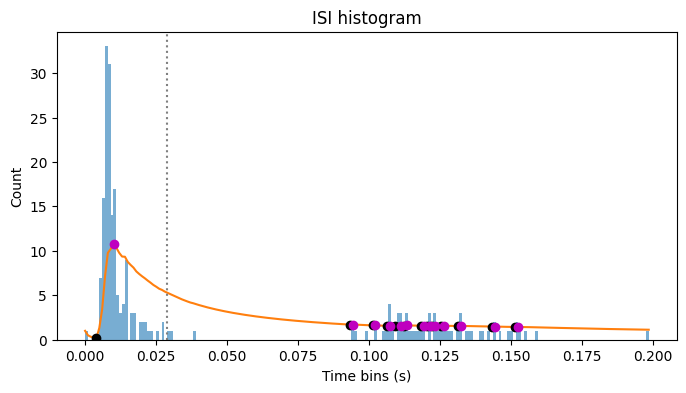

,mean_isi,median_isi,kurtosis,skewness,cma_threshold,cma_valley_time,cma_peak_time
0,0.04303,0.010406,44.242717,6.298225,0.029,0.093,0.01


In [15]:
# Assign ISI data to this variable
hist_data = spikes_table['isi_s']
 
# Empty DataFrame for histogram stats
hist_stats = pd.DataFrame()
 
# Bin size
bin_size = 1  # in miliseconds
 
# Histogram
isi_range = np.ptp(hist_data)
bins = int((isi_range * 1000 / bin_size) + 0.5)  # Round to the nearest integer
hist = np.histogram(hist_data, bins=bins)
hist_counts = hist[0]
hist_bins = hist[1]
 
# Cumulative moving average
cum = np.cumsum(hist_counts)  # Cumulative sum
cma = cum / np.arange(1, len(cum) + 1)
 
# Calculate peaks and valleys of the cma
cma_peaks_indexes = scipy.signal.argrelextrema(cma, np.greater)
cma_valleys_indexes = scipy.signal.argrelextrema(cma, np.less)
 
# Select the peak you're interested in
peak_index = cma_peaks_indexes[0][0]  # Change second number to select the peak
alpha = cma[peak_index] * 0.5  # Half-peak, adapt the value to your threshold criterion
 
# Calculate cma_threshold_index relative to the selected cma_peak
cma_threshold = (np.argmin(cma[peak_index:] >= alpha) + peak_index) * bin_size/1000
 
# Dataframe with histogram statistics
length = len(hist_stats)
hist_stats.loc[length, 'mean_isi'] = np.mean(hist_data)
hist_stats.loc[length, 'median_isi'] = np.median(hist_data)
hist_stats.loc[length, 'kurtosis'] = kurtosis(hist_counts)
hist_stats.loc[length, 'skewness'] = skew(hist_counts, bias=True)
hist_stats.loc[length, 'cma_threshold'] = cma_threshold
hist_stats.loc[length, 'cma_valley_time'] = cma_valleys_indexes[0][1] * bin_size/1000  # Change peak index as needed
hist_stats.loc[length, 'cma_peak_time'] = cma_peaks_indexes[0][0] * bin_size/1000  # Change peak index as needed
 
# Plot ISI histogram
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("ISI histogram") 
ax.hist(hist_data, bins=bins, alpha=0.6)
 
# Plot CMA
cma_x = np.linspace(np.min(hist_bins), np.max(hist_bins), bins)
ax.plot(cma_x, cma)
 
# Plot CMA threshold line
ax.axvline(cma_threshold, linestyle="dotted", color="gray")
 
# Plot CMA valleys
ax.plot(cma_x[cma_valleys_indexes], cma[cma_valleys_indexes], 'ko')
ax.plot(cma_x[cma_peaks_indexes], cma[cma_peaks_indexes], 'mo')
 
# ax.set_xscale('log')  # Logarithmic scale may be easier to set the threshold
ax.set_xlabel("Time bins (s)")
ax.set_ylabel("Count")
 
# Show graph and table
plt.show()
hist_stats

In [16]:
def burst_detection(df, spike_times, spike_amplitudes, spike_peaks,
                    n_spikes, 
                    max_isi, 
                    # min_duration,  # Optional
                    min_ibi):
     
    """
    Detects bursts in spike data based on spike times, 
    by identifying consecutive spikes that fulfill the criteria of:
    minimum number of spikes, maximum interspike interval, and minimum interburst interval.
     
    Arguments: 
        df: DataFrame with spike data.
        spike_times: Column name for spike positions.
        spike_amplitudes: Column name for spike amplitudes.
        spike_peaks: Column name for spike peak amplitudes. 
        n_spikes: Minimum number of spikes within a burst.
        max_isi: Max interspike interval within the burst.
        min_duration: Minimum burst duration.
        min_ibi: Minimum interburst interval (optional).
         
     
    Returns:
        DataFrame with burst information.
    """
     
    df = df.sort_values(by=spike_times)  # Sort DataFrame by spike positions
    df['burst'] = np.nan  # Create column for burst labels
    burst_num = 0        # Initialize burst number
    burst_start = None   # Initialize burst start position
    last_spike = None    # Initialize last spike position
 
    for i, row in df.iterrows():  # Loop through DataFrame rows 
        spike = row[spike_times]   # Extract the spike position 
         
        if burst_start is None:   # It checks if it is the first spike 
            burst_start = spike   # It marks the current spike position as the start of a burst
            last_spike = spike    # Update the last_spike position to the current spike position
            df.at[i, 'burst'] = burst_num   # Assign burst number
        elif spike - last_spike <= max_isi:  # It checks if the current spike is within max isi
            df.at[i, 'burst'] = burst_num  
            last_spike = spike 
        elif spike - last_spike > min_ibi:  # It checks if the interburst interval has been reached
            burst_num += 1 
            burst_start = spike 
            last_spike = spike  
            df.at[i, 'burst'] = burst_num  
     
    # Filter bursts with less than min_spikes
    df = df[df.groupby('burst')[spike_times].transform('count') >= n_spikes]
     
    # Filter burst shorter that min_duration (min_duration parameter)
    # df = df[df.groupby('burst')[spike_times].transform('max') 
    #         - df.groupby('burst')[spike_times].transform('min')
    #         >= min_duration]
     
    # Calculate burst information by aggregating single spike information
    bursts = df.groupby('burst')[spike_times].agg(['min', 'max', 'count'])
    bursts.columns = ['burst_start', 'burst_end', 'spikes_in_bursts']
    bursts['burst_length'] = bursts['burst_end'] - bursts['burst_start']
    bursts['avg_spike_amplitude'] = df.groupby('burst')[spike_amplitudes].mean()
    bursts['avg_spike_peaks'] = df.groupby('burst')[spike_peaks].mean()  
    bursts['spikes_frequency'] = bursts['spikes_in_bursts'] / bursts['burst_length']
    bursts = bursts.reset_index()
    bursts['burst_number'] = bursts.index + 1
     
     
    return bursts[['burst_number', 'burst_start', 'burst_end', 
                   'burst_length', 'spikes_in_bursts', 'avg_spike_amplitude', 
                   'avg_spike_peaks', 'spikes_frequency']]


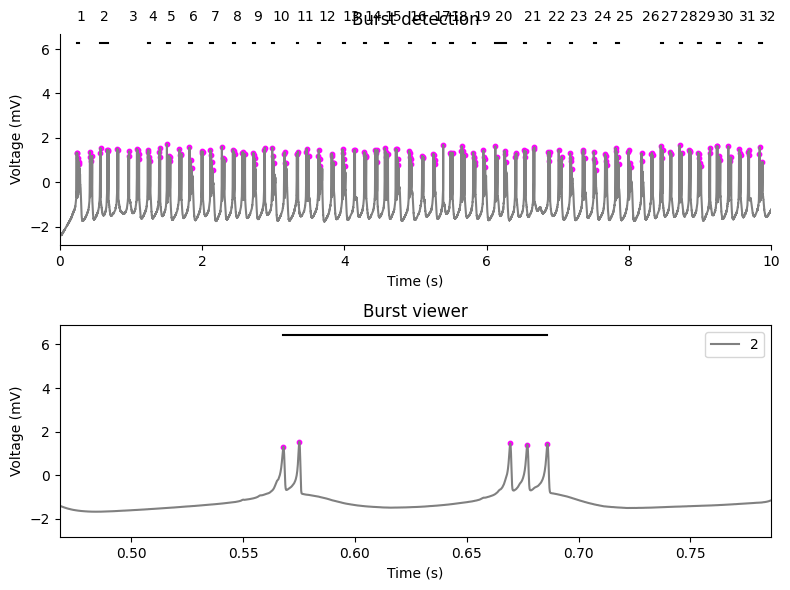

,burst_number,burst_start,burst_end,burst_length,spikes_in_bursts,avg_spike_amplitude,avg_spike_peaks,spikes_frequency
0,1,0.238904,0.275049,0.036145,5,1.915159,1.092198,138.331645
1,2,0.568091,0.686072,0.117981,5,2.472912,1.431530,42.379721
2,3,0.967847,0.975964,0.008118,2,2.294536,1.294618,246.375940
3,4,1.239612,1.274084,0.034473,4,2.153247,1.239004,116.033994
4,5,1.507751,1.555505,0.047754,5,2.094792,1.227407,104.703476
5,6,1.824414,1.856116,0.031702,3,2.077048,1.064272,94.632268
6,7,2.119543,2.149280,0.029736,4,1.890238,1.030464,134.515599
7,8,2.434607,2.457739,0.023132,3,2.419622,1.379980,129.688654
8,9,2.722449,2.747046,0.024597,4,1.976383,1.114733,162.620347
9,10,2.987598,3.010303,0.022705,3,2.235463,1.202868,132.129032


In [17]:
# Burst table
bursts = burst_detection(spikes_table,  # Dataframe with spike positions as input data  
                         'spike_time', 
                         'spike_amplitude',
                         'spike_peak',
                         n_spikes = 2,  
                         max_isi = 0.1,
                         # min_duration = 0.5,  # Optional
                         min_ibi = 0.2)  
 
 
# Plotting: create figure and axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
 
# Plot 1: trace and detected bursts
ax1.plot(time, peaks_signal, color='gray')
# Plot red dots for detected events
ax1.scatter(spikes_table['spike_time'], spikes_table['spike_peak'], color="magenta", s=10)
 
# Plot the detected bursts 
for i, burst in bursts.iterrows():
    burst_start = burst['burst_start']
    burst_end = burst['burst_end']
    burst_number = int(burst['burst_number'])
     
    # Set the height of the burst line
    # spike_peaks = burst['avg_spike_peaks'] + 5  # Option A
    spike_peaks = np.median(spikes_table.spike_peak) + 5  # Option B
     
    # Plot an horizontal line from beginning to the end of the bursts
    ax1.plot([burst_start, burst_end], [spike_peaks, spike_peaks], 'black')
    # Annotate each line with the burst number
    ax1.annotate(str(burst_number),  xy=(burst_start, spike_peaks), 
                xytext=(burst_start, spike_peaks + 1))
 
# Set title and show plot
ax1.set_title("Burst detection") 
ax1.set_ylabel("Voltage (mV)")
ax1.set_xlabel("Time (s)")
 
# Remove top and right frame borders
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.axes.set_xlim(0, 10)  # OptionaL: Zoom in the trace
 
# Plot 2: single burst 
ax2.set_title("Burst viewer")
burst_number = 2  # Change here the burst number
 
# Plot the signal with detected spikes
ax2.plot(time, peaks_signal, color='gray', label=burst_number)
ax2.scatter(spikes_table['spike_time'], spikes_table['spike_peak'], color="magenta", s=10)
 
# Burst time window + 0.1 s before and after
burst_start = bursts.loc[bursts['burst_number'] == burst_number, 'burst_start'].values[0]
burst_end = bursts.loc[bursts['burst_number'] == burst_number, 'burst_end'].values[0]
burst_line_y = bursts.loc[bursts['burst_number'] == burst_number, 'avg_spike_peaks'].values[0] + 5
ax2.plot([burst_start, burst_end], [burst_line_y, burst_line_y], 'black')
ax2.set_xlim(burst_start - 0.1, burst_end + 0.1) 
 
# Label the plot
ax2.set_ylabel("Voltage (mV)")
ax2.set_xlabel("Time (s)")
ax2.legend()
 
# Display the plots and table
fig.tight_layout()
plt.show()
bursts

In [18]:
# Experiment ID
experiment_id = ca
 
# Summary statistics
burst_number = len(bursts)
spikes_in_bursts = np.sum(bursts.spikes_in_bursts)
spikes_bursts_pct = (spikes_in_bursts / len(spikes_table.spike)) * 100
mean_burst_duration = np.mean(bursts.burst_length)
 
# Create a DataFrame 
bursts_stats = pd.DataFrame({
    'Experiment_ID': experiment_id,
    'Number of bursts': [burst_number],
    'Spikes in Bursts': [spikes_in_bursts],
    'Spikes in Bursts (%)': [spikes_bursts_pct],
    'Mean Burst Duration': [mean_burst_duration]
})
 
bursts_stats

,Experiment_ID,Number of bursts,Spikes in Bursts,Spikes in Bursts (%),Mean Burst Duration
0,0306A,32,122,54.464286,0.035552
